In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickles
plt.style.use('fivethirtyeight')
%matplotlib inline

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [10]:
final = pd.read_pickle("./pickles/final.pkl")
test_set = pd.read_pickle("./pickles/test.pkl")
final.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech_gadgets-min,tech_gadgets-sum,tech_gadgets-std,tech_gadgets-range_,female-head
0,0,0,1,1,1,0,0,0,0,0,...,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0,0
1,0,0,1,1,0,0,0,0,0,1,...,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0,0
2,0,0,1,1,0,0,0,0,0,1,...,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0,1
3,0,0,1,1,1,0,0,0,0,0,...,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0,0
4,1,0,1,1,1,0,0,0,0,0,...,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0,0


In [11]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extracting the training/testing set
train_on = final[final['Target'].notnull()]
train_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

test_on = final[final['Target'].isnull()]
test_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

# Submission base which is used for making submissions to the competition
submission_base = test_set[['Id', 'idhogar']].copy()

/Users/alexguanga/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
# Fixing missing values

p

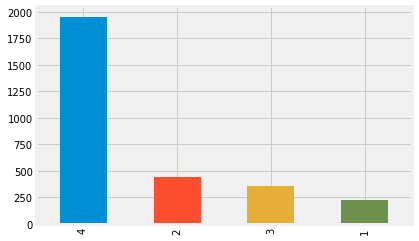

In [13]:
pd.DataFrame({'train_labels': train_labels})['train_labels'].value_counts().plot(kind='bar')

In [14]:
# Quick Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1)

# 10 fold cross validation
cv_score = cross_val_score(model, train_on, train_labels, cv=10, scoring=scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3405 with std = 0.0395


## Feature Importance

In [15]:
model.fit(train_on, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000812
1,hacapo,0.000377
2,v14a,0.000500
3,refrig,0.002006
4,paredblolad,0.006893


In [16]:
def plot_feature_importances(df, n = 10, threshold = None):
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

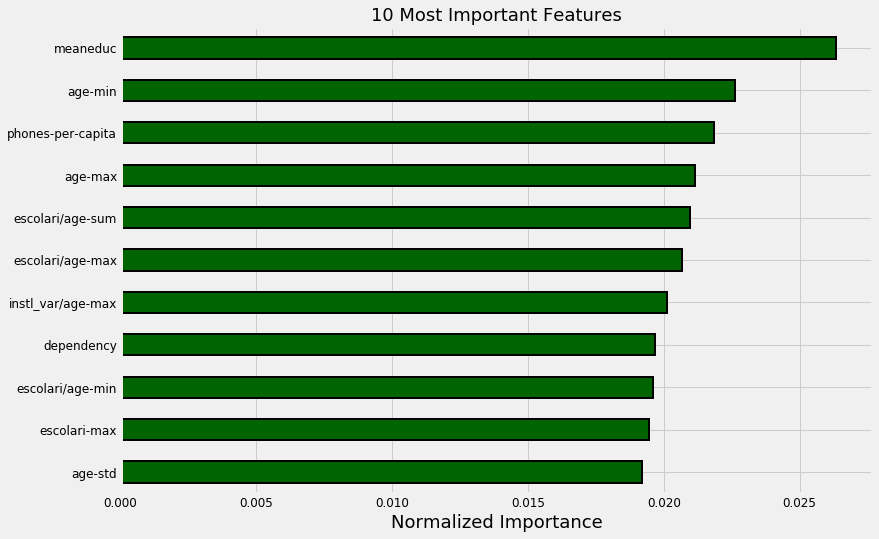

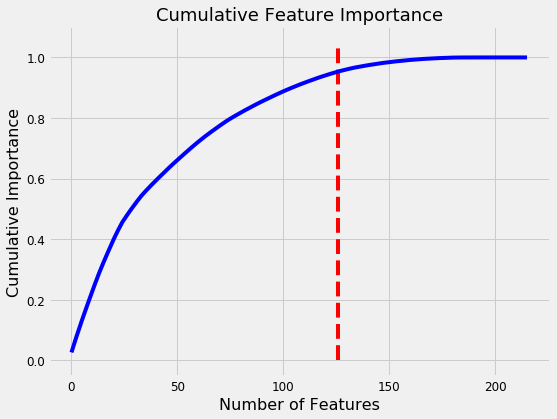

126 features required for 95% of cumulative importance.


In [17]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)


Notes:
- Realize that we do not need all the variable to have a high importance of the data
- Also, the importance does not tell its affect on the target variable
- Lastly, we need to be reassured of the variables that could be correlated with one another.

In [18]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}
    plt.figure(figsize = (14, 6))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

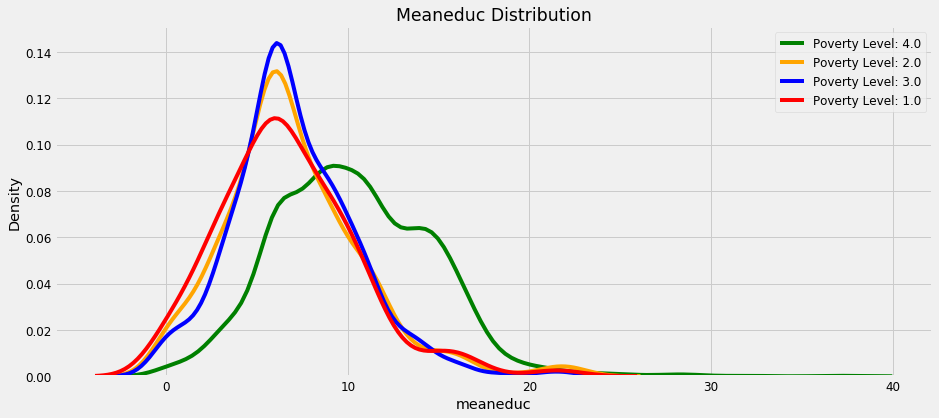

In [19]:
kde_target(final, 'meaneduc')

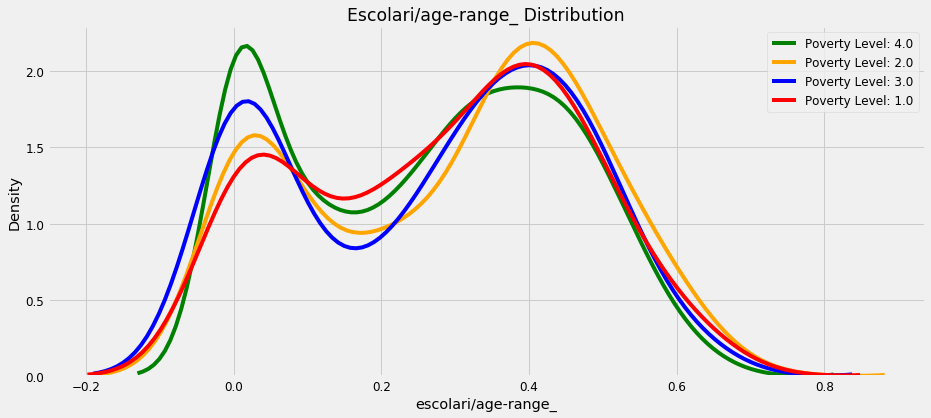

In [20]:
kde_target(final, 'escolari/age-range_')

## Modeling

In [21]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [22]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                           'cv_std': cv_scores.std()},
                                                           index = [0]), ignore_index = True)

        return model_results

In [23]:
# LSVC Model
model_results = cv_model(train_on, train_labels, LinearSVC(), 'LSVC', model_results)

10 Fold CV Score: 0.29043 with std: 0.0491


In [24]:
# Gaussian Model
model_results = cv_model(train_on, train_labels, GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.1958 with std: 0.04638


In [25]:
# The multi-layer perceptron
model_results = cv_model(train_on, train_labels, MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.30889 with std: 0.06069


In [26]:
# If you run LinearDiscriminantAnalysis without filtering out the UserWarnings, you get many messages saying 
# "Variables are collinear." This might give us a hint that we want to remove some collinear features! 

model_results = cv_model(train_on, train_labels, LinearDiscriminantAnalysis(), 'LDA', model_results)

10 Fold CV Score: 0.31704 with std: 0.06514


In [27]:
# Ridge Regression
model_results = cv_model(train_on, train_labels, RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27786 with std: 0.03989


In [28]:
# KNN Model with three parameters
for n in [2, 10, 20]:
    print(f'\nKNN with {n} neighbors')
    model_results = cv_model(train_on, train_labels, KNeighborsClassifier(n_neighbors=n), f'KK-{n}', model_results)
          


KNN with 2 neighbors
10 Fold CV Score: 0.32057 with std: 0.03758

KNN with 10 neighbors
10 Fold CV Score: 0.32686 with std: 0.0315

KNN with 20 neighbors
10 Fold CV Score: 0.31206 with std: 0.0425


In [29]:
# Extra Tree Classifier
model_results = cv_model(train_on, train_labels, ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.32839 with std: 0.04611


In [30]:
# Random Forest Classifier
model_results = cv_model(train_on, train_labels, RandomForestClassifier(100, random_state=10),
                         'RF', model_results)

10 Fold CV Score: 0.34053 with std: 0.0395


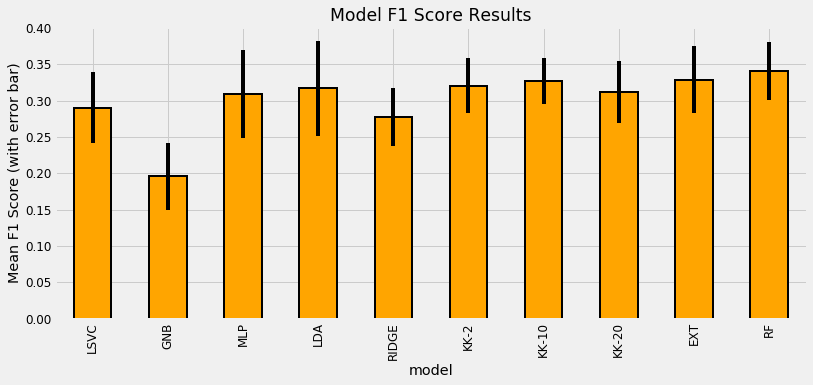

In [31]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (12, 5),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');

In [32]:
# Reseting the index
model_results.reset_index(inplace=True)

## Submission

The submission_base will have all the individuals in the test set since we have to have a "prediction" for each individual while the test_ids will only contain the idhogar from the heads of households. When predicting, we only predict for each household and then we merge the predictions dataframe with all of the individuals on the household id (idhogar). This will set the Target to the same value for everyone in a household. For the test households without a head of household, we can just set these predictions to 4 since they will not be scored.

In [ ]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])


In [ ]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Make a submission dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Fill in households missing a head
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

In [ ]:
def get_corrs_matrix(data, corr_threshold=.95):
    corr_matrix = data.corr()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [c for c in upper.columns if any(abs(upper[c]) > corr_threshold)]
    return [corr_matrix, to_drop]

In [ ]:
# We will continue to remove values that deserve to be removed

train_on = pd.DataFrame(train_on, columns=features)
corr_matrix, to_drop = get_corrs_matrix(train_on)
to_drop

In [ ]:
train_on = train_on.drop(to_drop, axis=1)
train_on.shape

In [ ]:
# Setting up the testing set
test_on = pd.DataFrame(test_on, columns=features)
train_on, test_on = train_on.align(test_on, axis=1, join='inner')
features = list(train_on.columns)

In [ ]:
train_on.head(5)

In [ ]:
test_on.head(5)

### Improving Models: Recursive Feature Elimination with Random Forest

In [ ]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state=10, n_estimators=100,  n_jobs=-1)

# Create the object]
selector = RFECV(estimator, step=1, cv=3, scoring=scorer, n_jobs=-1)

In [ ]:
# Fitting the object with the RF model
selector.fit(train_on, train_labels)

In [ ]:
# Plotting the Recursive Feature Elimination
plt.plot(selector.grid_scores_);
plt.xlabel('# of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores')

selector.n_features_

In [ ]:
# The ranking of the features
rankings = pd.DataFrame({'feature': train_on.columns.tolist(), 
                        'rank': selector.ranking_.tolist()}).sort_values('rank')
rankings.head(10)

In [ ]:
# Using the features we obtained, we now have to use to train the model
train_selected = selector.transform(train_on)
test_selected = selector.transform(test_on)

# Converting back into a dataframe
selected_features = train_on.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns=selected_features)
test_selected = pd.DataFrame(test_selected, columns=selected_features)

# Training the model
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

In [ ]:
def plot_model_scores(model_results):
    model_results.set_index('model', inplace = True)
    model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6), 
                                      yerr = list(model_results['cv_std']),
                                      edgecolor = 'k', linewidth = 2)

    plt.title('Model F1 Score Results');
    plt.ylabel('Mean F1 Score (with error br)');
    model_results.reset_index(inplace = True)
    

In [ ]:
plot_model_scores(model_results)

## Advanced Modeling: Gradient Boosting Machine


From Blog Post:
- Choosing Number of Estimators with Early Stopping
    - To choose the number of estimators (the number of decision trees in the ensemble, called ``n_estimators`` or ``num_boost_rounds``), we'll use early stopping with 5-fold cross validation. This will keep adding estimators until the performance as measured by the Macro F1 Score has not increased for 100 training rounds. To use this metric, we'll have to define a custom metric.

In [ ]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

###  Light Gradient Boosting Implementation

From Blog Post:
- Choosing hyperparameters for the Gradient Boosting Machine can be tough and generally is done through model optimization. In this notebook, we'll use a set of hyperparameters that I've found work well on previous problems (although they will not necessarily translate to this competition).
- We set the ``n_estimators`` to 10000 but we won't actually reach this number because we are using ``early stopping`` which will quit training estimators when the cross validation metric does not improve for early_stopping_rounds. There's a lot going on in this function, and read through it carefully to make sure you have it all! I've tried to make the comments and code straightforward. (The display is used to show custom information during training in combination with %%capture so we don't have to see all the LightGBM information during training).

In [ ]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds=5, return_preds=False, hyp=None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                  'min_child_samples': 10, 
                  'num_leaves': 36, 'reg_alpha': 0.76, 
                  'reg_lambda': 0.43, 
                  'subsample_for_bin': 40000, 
                  'subsample': 0.54, 
                  'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective='multiclass', n_jobs=-1, 
                               n_estimators=10000, #n_estimators is 10000: large enough to have no affect
                               random_state=10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits=nfolds, shuffle=True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds=100, 
                  eval_metric=macro_f1_score,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_names=['train', 'valid'],
                  verbose=200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

Notes:
- **Cross Validation with Early Stopping Notes**
    - Cross validation with early stopping is one of the most effective methods for preventing overfitting on the training set because it prevents us from continuing to add model complexity once it is clear that validation scores are not improving. Repeating this process across multiple folds helps to reduce the bias that comes from using a single fold. Early stopping also lets us train the model much quicker. 

In [ ]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_on, train_labels, test_on, test_ids, return_preds=True)

In [ ]:
predictions.head()

In [ ]:
# Plotting the confidence, or highest probability, of each of the target
# for each of the folds
plt.rcParams['font.size'] = 18

# Kdeplot
g = sns.FacetGrid(predictions, row='fold', hue='Target', size=3, aspect=4)
g.map(sns.kdeplot, 'confidence');
g.add_legend();

plt.suptitle('Distribution of Confidence by Fold and Target', y = 1.05);

In [ ]:
# Currently, our data is inbalanced, Target 4 has the mose values 
# Note, why is the target 4 the most frequent target, wasn't it target 1? did the values changes?

predictions = predictions.groupby('idhogar', as_index=False).mean()

# Getting the target index with the highest prob
predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis=1)

# Getting the target value with the highest prob
predictions['Confidence'] = predictions[[1, 2, 3, 4]].max(axis=1)

# Removing the specific fold
predictions.drop('fold', axis=1, inplace=True)

# Plotting the confidence by eachh target
plt.figure(figsize = (10, 6))
sns.boxplot(x='Target', y='confidence', data=predictions);
plt.title('Confidence by Target');

plt.figure(figsize = (10, 6))
sns.violinplot(x='Target', y='confidence', data=predictions);
plt.title('Confidence by Target');

In [ ]:
predictions.head(5)

Notes:
- We can have the function instead return the actual submission file. This takes the average predictions across the five folds, in effectm combining 5 different models, each one trained on a slghtly different subset of the data.

In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_on, train_labels, 
                                             test_on, test_ids, return_preds=False)

submission.to_csv('gbm_baseline.csv')

In [ ]:
_ = plot_feature_importances(gbm_fi, threshold=0.95)

In [ ]:
%%capture --no-display
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, 
                                                               test_selected, test_ids)


In [ ]:
# Append the result of previous to our dictionary
model_results = model_results.append(pd.DataFrame({'model': ["GBM", "GBM_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}),
                                     sort = True)

In [ ]:
# Plotting the performance of our models
plot_model_scores(model_results)

In [ ]:
# Making the model a 10-fold

In [ ]:
%%capture
submission, gbm_fi_10fold, valid_scores = model_gbm(train_on, train_labels, test_on, test_ids, 
                                             nfolds=10, return_preds=False)

In [58]:
submission.to_csv('gbm_10fold.csv', index=False)

In [59]:
%%capture
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, 
                                                               test_selected, test_ids,
                                                               nfolds=10)

In [60]:
submission.to_csv('gmb_10fold_selected.csv', index = False)

In [61]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_10Fold", "GBM_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}),
                                    sort = True)

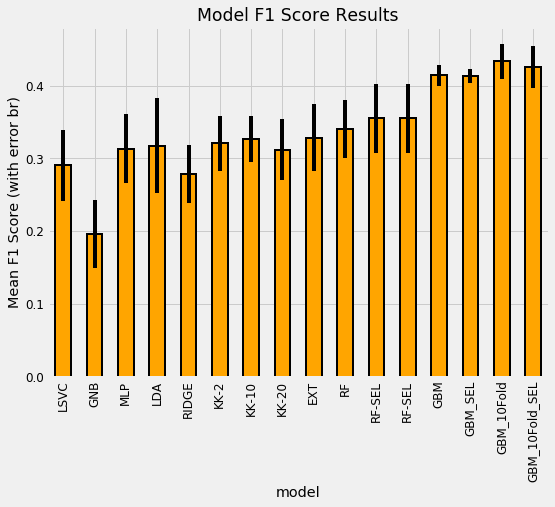

In [62]:
plot_model_scores(model_results)

Notes:
- The best model seems to be the Gradient Boosting Machine trained with 10 folds on the selected features. This model has not yet been optimized, but we might be able to get a little more performance through optimization.

In [63]:
print(f"There are {gbm_fi_selected[gbm_fi_selected['importance'] == 0].shape[0]} features with no importance.")

There are 0 features with no importance.


Notes:
- All of the features we are using have some importance to the Gradient Boosting Machine. It might be a good idea to go back and retry feature selection but with the GBM since that is the model we are using.

## Model Optimizations: Automated Optimization

Bayesian optimization requires 4 parts:

1. Objective function: what we want to maximize (or minimize)
2. Domain space: region over which to search
3. Algorithm for choosing next hyperparameters: uses past results to suggest next values
4. Results history: saves the past results

In [64]:
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

import csv
import ast
from timeit import default_timer as timer

### 1. Objective Function


In [65]:
def objective(hyperparameters, nfolds=5):
    """Return validation score from hyperparameters for LightGBM"""
    
    # Keep track of evals
    global ITERATION
    ITERATION += 1
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    subsample_freq = hyperparameters['boosting_type'].get('subsample_freq', 0)
    
    boosting_type = hyperparameters['boosting_type']['boosting_type']
    
    if boosting_type == 'dart':
        hyperparameters['drop_rate'] = hyperparameters['boosting_type']['drop_rate']
    
    # Subsample and subsample frequency to top level keys
    hyperparameters['subsample'] = subsample
    hyperparameters['subsample_freq'] = subsample_freq
    hyperparameters['boosting_type'] = boosting_type
    
    # Whether or not to use limit maximum depth
    if not hyperparameters['limit_max_depth']:
        hyperparameters['max_depth'] = -1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['max_depth', 'num_leaves', 'subsample_for_bin', 
                           'min_child_samples', 'subsample_freq']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Convert to arrays for indexing
    features = np.array(train_selected)
    labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    best_estimators = []
    run_times = []
    
    model = lgb.LGBMClassifier(**hyperparameters, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None',
                               n_estimators=10000)
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        start = timer()
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 400)
        end = timer()
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        best_estimators.append(model.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    estimators = int(np.mean(best_estimators))
    hyperparameters['n_estimators'] = estimators
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, score, score_std])
    of_connection.close()
    
    # Display progress
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

### 2. Search Space

In [66]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

In [67]:
sample(space)

{'boosting_type': {'boosting_type': 'goss',
  'subsample': 1.0,
  'subsample_freq': 0},
 'colsample_bytree': 0.5709365274312216,
 'learning_rate': 0.031697939669080015,
 'limit_max_depth': False,
 'max_depth': 9.0,
 'min_child_samples': 40.0,
 'num_leaves': 15.0,
 'reg_alpha': 0.21485206223069397,
 'reg_lambda': 0.23618753936058567,
 'subsample_for_bin': 14000.0}

### 3. Algorithm

The algorithm for choosing the next values is the Tree Parzen Estimator which uses Bayes rule for constructing a surrogate model of the objective function. Instead of maximizing the objective function, the algorithm maximizes the Expected Improvement (EI) of the surrogate model.

In [68]:
algo = tpe.suggest

### 4. Results History

We'll use two different methods for recording results:
- Trials object: stores everything returned from the objective function
- Write to a csv file on every iteration


I like using multiple methods for tracking progress because it means redundancy. One way may fail, but hopefully both will not! The csv file can be used to monitor the method while it is running and the Trials object can be saved and then reloaded to resume optimization.

In [69]:
# Record results
trials = Trials()

# Create a file and open a connection
OUT_FILE = 'optimization.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

MAX_EVALS = 100
PROGRESS = 10
N_FOLDS = 5
ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score', 'std']
writer.writerow(headers)
of_connection.close()

In [74]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Run optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=MAX_EVALS)

'Running Optimization for 100 Trials.'

'Iteration: 10, Current Score: 0.4263.'

'Iteration: 20, Current Score: 0.4336.'

'Iteration: 30, Current Score: 0.4213.'

'Iteration: 40, Current Score: 0.4313.'

'Iteration: 50, Current Score: 0.4327.'

'Iteration: 60, Current Score: 0.4247.'

'Iteration: 70, Current Score: 0.4287.'

'Iteration: 80, Current Score: 0.4273.'

'Iteration: 90, Current Score: 0.4455.'

'Iteration: 100, Current Score: 0.4445.'

In [75]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(str(trials)))


In [76]:
results = pd.read_csv(OUT_FILE).sort_values('loss', ascending=True).reset_index()
results.head()

,index,loss,hyperparameters,iteration,runtime,score,std
0,61,0.547587,"{'boosting_type': 'dart', 'colsample_bytree': ...",62,10.730562,0.452413,0.013249
1,89,0.554535,"{'boosting_type': 'dart', 'colsample_bytree': ...",90,9.294802,0.445465,0.020549
2,31,0.555021,"{'boosting_type': 'dart', 'colsample_bytree': ...",32,4.702208,0.444979,0.014372
3,99,0.555531,"{'boosting_type': 'dart', 'colsample_bytree': ...",100,11.478803,0.444469,0.021118
4,65,0.556293,"{'boosting_type': 'goss', 'colsample_bytree': ...",66,0.996220,0.443707,0.022137


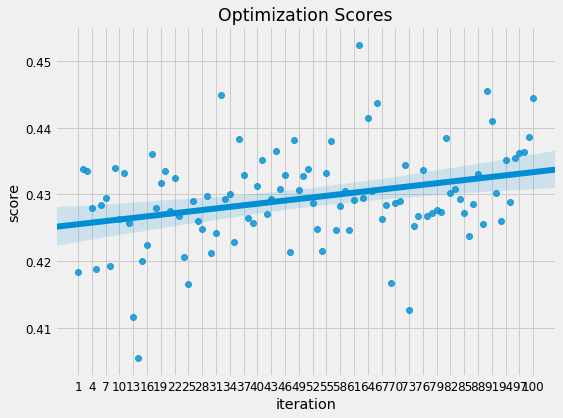

In [77]:
plt.figure(figsize = (8, 6))
sns.regplot('iteration', 'score', data = results);
plt.title("Optimization Scores");
plt.xticks(list(range(1, results['iteration'].max() + 1, 3)));

In [78]:
best_hyp = ast.literal_eval(results.loc[0, 'hyperparameters'])
best_hyp

{'boosting_type': 'dart',
 'colsample_bytree': 0.6656610653879056,
 'learning_rate': 0.15654386057087114,
 'limit_max_depth': False,
 'max_depth': -1,
 'min_child_samples': 25,
 'num_leaves': 28,
 'reg_alpha': 0.34028648714401466,
 'reg_lambda': 0.4969925318931504,
 'subsample_for_bin': 60000,
 'drop_rate': 0.39401307778070693,
 'subsample': 0.9522476606817002,
 'subsample_freq': 6,
 'n_estimators': 86}

In [83]:
%%capture
sub_gbm_opt_10fold_sel, gbm_fi_opt_10fold_sel, valid_scores = model_gbm(train_selected, train_labels, 
                                             test_selected, test_ids, 
                                             nfolds=10, hyp=best_hyp, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [16]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_on, train_labels, 
                                             test_on, test_ids, 
                                             nfolds=10, hyp=best_hyp, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)


NameError: name 'model_gbm' is not defined

In [84]:
model_results.head(10)

,cv_mean,cv_std,model
14,0.433122,0.024496,GBM_10Fold
15,0.425541,0.029268,GBM_10Fold_SEL
0,0.417161,0.028835,GBM_OPT_10Fold_SEL
0,0.414255,0.036250,GBM_OPT_10Fold
12,0.414023,0.014316,GBM
13,0.412712,0.009896,GBM_SEL
0,0.399565,0.032698,GBM_OPT_10Fold_SEL
11,0.355147,0.047267,RF-SEL
10,0.355147,0.047267,RF-SEL
9,0.340525,0.039503,RF


In [85]:
sub_gbm_opt_10fold_sel.to_csv('gbm_opt_10fold_selected.csv', index=False)

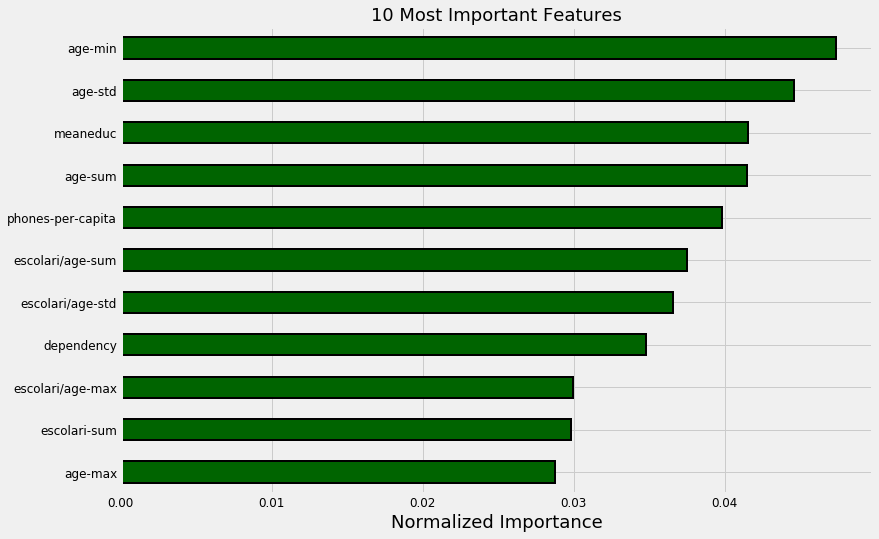

In [86]:
_ = plot_feature_importances(gbm_fi_opt_10fold_sel)

In [94]:
# Comparing the target variables across the training and testing set
preds = submission_base.merge(sub_gbm_opt_10fold_sel, on='Id', how='left')
preds = pd.DataFrame(preds.groupby('idhogar')['Target'].mean())
preds.shape

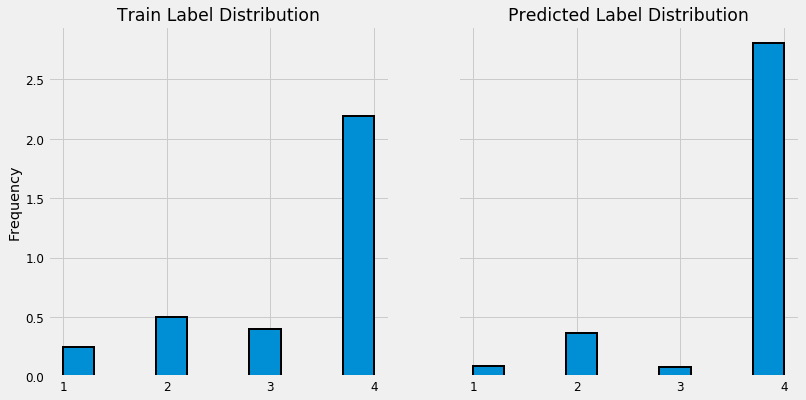

In [89]:
# Plot the training labels distribution
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
final['Target'].sort_index().plot.hist(normed = True,
                                       edgecolor = r'k',
                                       linewidth = 2,
                                       ax = axes[0])

axes[0].set_xticks([1, 2, 3, 4]);
axes[0].set_title('Train Label Distribution')

# Plot the predicted labels
preds['Target'].sort_index().plot.hist(normed = True, 
                                       edgecolor = 'k',
                                       linewidth = 2,
                                       ax = axes[1])
axes[1].set_xticks([1, 2, 3, 4]);
plt.subplots_adjust()
plt.title('Predicted Label Distribution');

In [100]:
final['Target'].value_counts()

4.0    1954
2.0     442
3.0     355
1.0     222
Name: Target, dtype: int64

In [101]:
preds['Target'].value_counts()

4    6187
2     820
1     180
3     165
Name: Target, dtype: int64

Notes:
- The predicted distribution looks close to the training distribution although there are some differences. Depending on the run of the notebook, the results you see may change, but for this edition, the 4s are underrepresented in the predictions and the 3s are overrepresented.
- One potentially method for dealing with imbalanced classification problems is oversampling the minority class, which is easy to do in Python using the imbalanced learn library. We won't explore that option here.

## Model Optimization: Train on the Validation Set

In [102]:
from sklearn.model_selection import train_test_split

# Split into validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_selected,
                                                      train_labels,
                                                      test_size = 1000,
                                                      random_state = 10)

# Create model and train
model = lgb.LGBMClassifier(**best_hyp, 
                           class_weight = 'balanced',
                           random_state = 10)
model.fit(X_train, y_train);

In [103]:
# Make validation predictions
valid_preds = model.predict_proba(X_valid)
preds_df = pd.DataFrame(valid_preds, columns = [1, 2, 3, 4])

# Convert into predictions
preds_df['prediction'] = preds_df[[1, 2, 3, 4]].idxmax(axis = 1)
preds_df['confidence'] = preds_df[[1, 2, 3, 4]].max(axis = 1)

preds_df.head()

,1,2,3,4,prediction,confidence
0,0.092974,0.070449,0.048534,0.788043,4,0.788043
1,0.030688,0.034598,0.026426,0.908289,4,0.908289
2,0.040777,0.111144,0.390535,0.457544,4,0.457544
3,0.217870,0.409564,0.289867,0.082700,2,0.409564
4,0.058482,0.225054,0.600872,0.115592,3,0.600872


In [104]:
print('F1 score:', round(f1_score(y_valid, preds_df['prediction'], average = 'macro'), 5))


F1 score: 0.43528


In [105]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 26  18  17  19]
 [ 23  53  30  33]
 [ 13  24  38  38]
 [ 19  69  80 500]]


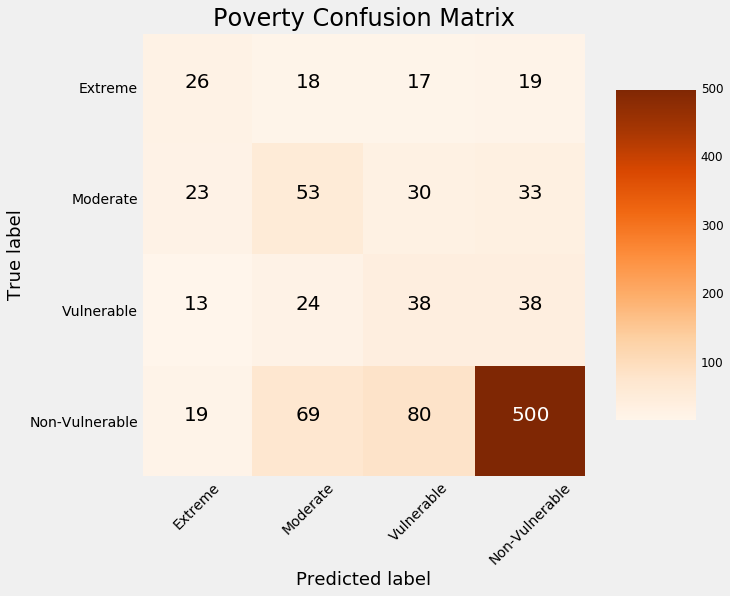

In [106]:
cm = confusion_matrix(y_valid, preds_df['prediction'])

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

Notes:
- Any values in the diagnoal are responses we got right. Any value not on the diagnol can be disected by viewing the true and what we predicted!

Normalized confusion matrix
[[0.325      0.225      0.2125     0.2375    ]
 [0.16546763 0.38129496 0.21582734 0.23741007]
 [0.11504425 0.21238938 0.33628319 0.33628319]
 [0.02844311 0.10329341 0.11976048 0.74850299]]


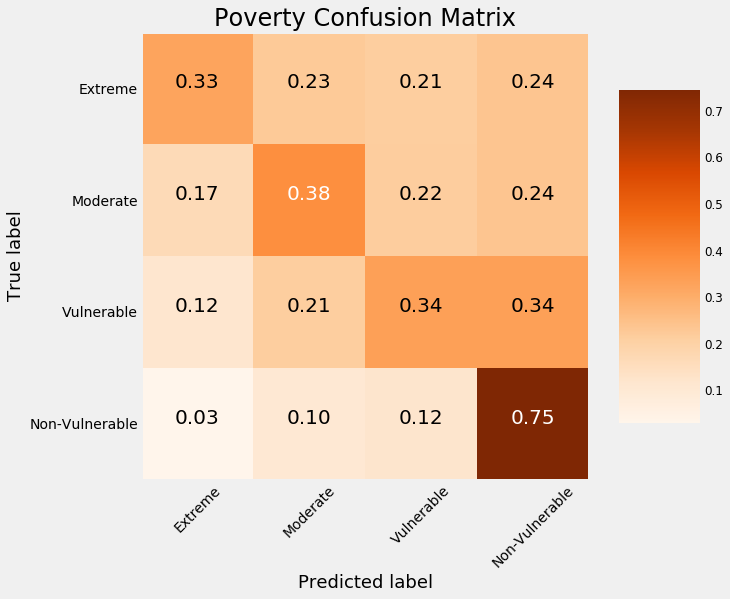

In [107]:
plot_confusion_matrix(cm, normalize = True,
                      classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

Notes:
- Now we can see that our model really does not do that well for classes other than Non Vulnerable.
- Overall, these results show that imbalanced classification problems with relatively few observations are very difficult. There are some methods we can take to try and counter this such as oversampling or training multiple models on different sections of the data, but at the end of the day, the most effective method may be to gather more data.

In [109]:
# Saving Models for advances techniques
train_selected.to_pickle('./pickles/train_selected.pkl')
test_selected.to_pickle('./pickles/test_selected.pkl')